In [1]:
!echo $(python --version)
!echo $(pip --version)

Python 3.6.7
pip 19.0.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


In [2]:
%matplotlib inline

In [3]:
!catalyst ingest-exchange -x binance -f daily

Trying to ingest exchange bundle binance...


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
# import pyfolio as pf

from catalyst.utils.run_algo import run_algorithm
from catalyst.api import order_target_percent, record, symbol
from catalyst.exchange.utils.exchange_utils import get_exchange_symbols

In [5]:
BASE_CAPITAL = 1
BASE_CURRENCY = 'btc'
EXCHANGE_NAME = 'binance'
START_DATE = '2018-01-01'
END_DATE = '2019-01-01'
FREQUENCY = '1D' # 1T (minutes), 1H (hours) or 1D (days).
API_FREQUENCY = FREQUENCY == '1D' and 'daily' or 'minute'
SHORT_EMA_LENGTH = 5
LONG_EMA_LENGTH = 20
DISABLED_MARKETS = [
    'omg_btc',
]

In [6]:
# TODO: Document properly.
def datetime_date(datetime):
    return datetime.strftime('%Y-%m-%d')

In [7]:
def get_market_label(market_key):
    """Get a label from a market key.

    Parameters
    ----------
    market_key : str
        The market key to format.

    Returns
    -------
    market_label : str
        The market_key formatted as a label.
    """

    return market_key.upper().split('_')[0]

In [8]:
def frequency_in_minutes(frequency):
    """Get the frequency as an amount of minutes.

    Parameters
    ----------
    frequency : str
        1T (minutes), 1H (hours) or 1D (days).

    Returns
    -------
    frequency_minutes : int
        The frequency expressed as an amount of minutes.
    """

    if frequency == '1T':
        return 1
    elif frequency == '1H':
        return 60
    elif frequency == '1D':
        return 60 * 24

In [9]:
def initialize(context):
    """Initializes the backtest.

    Parameters
    ----------
    context : catalyst.ExchangeTradingAlgorithmBacktest
        The backtest object. This is used as shared state and to collect results.
    """

    context.i = -1
    context.exchange = 'binance'
    context.quote_currency = 'btc'
    context.frequency = FREQUENCY
    context.loop_interval = FREQUENCY == '1D' and 1 or frequency_in_minutes(FREQUENCY)
    context.short_sma_length = SHORT_EMA_LENGTH
    context.short_sma_frequency = FREQUENCY
    context.long_sma_length = LONG_EMA_LENGTH
    context.long_sma_frequency = FREQUENCY
    context.universe = universe(
        context,
        datetime_date(context.sim_params.start_session),
        datetime_date(context.sim_params.end_session)
    )

    print('Universe Size: %s' % (len(context.universe)))

In [10]:
# TODO: Document properly.
def universe(context, start_date, end_date):
    """Returns a list of symbols to trade."""
    
    # get all the pairs for the given exchange
    json_symbols = get_exchange_symbols(context.exchange)

    # convert into a DataFrame for easier processing
    df = pd.DataFrame.from_dict(json_symbols).transpose().astype(str)
    df['quote_currency'] = df.apply(
        lambda row: row.symbol.split('_')[1],
        axis=1
    )
    df['base_currency'] = df.apply(
        lambda row: row.symbol.split('_')[0],
        axis=1
    )
    
    # print('universe df all pairs %s %s' % (len(df), df.symbol.tolist()))

    # Filter all the pairs to get only the ones for a given quote_currency
    df = df[df['quote_currency'] == context.quote_currency]
    
    # print('universe df quote pairs %s %s' % (len(df), df.symbol.tolist()))
    # print('universe df too late pairs %s %s' % (len(df[df.start_date < start_date]), df[df.start_date < start_date].symbol.tolist()))
    # print('universe df too early pairs %s %s' % (len(df[df.end_daily > end_date]), df[df.end_daily > end_date].symbol.tolist()))

    # Filter all pairs to ensure that pair existed in the current date range
    df = df[df.start_date < start_date]
    df = df[df.end_daily > end_date]

    # print('universe df after dates end: %s' % (len(df)))
    
    filtered_universe = [x for x in df.symbol.tolist() if x not in DISABLED_MARKETS]

    # print('universe df after filter: %s' % (len(df)))
    
    for x in filtered_universe:
        print(x)

    return filtered_universe


In [11]:
# TODO: Document properly.
def analyze(context, results):
    """Analyzes the results when the backtest is done."""

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8, 12))

    results[['cash']].plot(ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.legend(['Cash (BTC)'])

    results[['returns']].plot(ax=ax2)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.legend(['Returns (BTC)'])

    # plt.subplots_adjust(hspace=2.0)
    plt.tight_layout()
    plt.show()

In [12]:
def recalculate(context, bar_data):
    """Returns the values for the algorithm for each Asset for this Bar.

    Parameters
    ----------
    context : di
        Represents the backtest state.
    bar_data : catalyst._protocol.BarData
        The data for the current period.
    """

    context.values = {}

    for market_key in context.universe:
        market_symbol = symbol(market_key)

        # Get the current price.
        price_value = bar_data.current(market_symbol, 'price')

        # Calculate the Short SMA.
        short_sma_data = bar_data.history(
            market_symbol,
            'price',
            bar_count=context.short_sma_length,
            frequency=context.short_sma_frequency,
        )
        short_sma_value = short_sma_data.mean()

        # Calculate the Long EMA.
        long_sma_data = bar_data.history(
            market_symbol,
            'price',
            bar_count=context.long_sma_length,
            frequency=context.long_sma_frequency,
        )
        long_sma_value = long_sma_data.mean()

        # Save data per market in the context.
        context.values[market_key] = {
            'price': price_value,
            'short_sma': short_sma_value,
            'long_sma': long_sma_value,
        }

In [13]:
def rebalance(context, bar_data):
    """Opens Buy and Sell orders and closes orders for this Bar.

    Parameters
    ----------
    context : catalyst.exchange.exchange_algorithm.ExchangeTradingAlgorithmBacktest
        Represents the backtest state.
    bar_data : catalyst._protocol.BarData
        The data for the current period.
    """

    # Wait until all orders are executed before considering more trades.
    orders = context.blotter.open_orders
    if len(orders) > 0:
        return

    open_market_symbols = []
    close_market_symbols = []

    for market_key in context.universe:
        market_symbol = symbol(market_key)

        # Exit if we cannot trade.
        if not bar_data.can_trade(market_symbol):
            return

        # We check what's our position on our portfolio and trade accordingly.
        market = context.values[market_key]

        if market['short_sma'] > market['long_sma']:
            open_market_symbols.append(market_symbol)
        elif market['short_sma'] < market['long_sma']:
            close_market_symbols.append(market_symbol)

    for market_symbol in close_market_symbols:
        if context.portfolio.positions[market_symbol].amount > 0:
            order_target_percent(market_symbol, 0)

    target_percent = 1 / len(open_market_symbols)
    for market_key in open_market_symbols:
        order_target_percent(market_key, target_percent)

In [14]:
def handle_data(context, bar_data):
    """Get the frequency as an amount of minutes.

    Parameters
    ----------
    context : catalyst.exchange.exchange_algorithm.ExchangeTradingAlgorithmBacktest
        Represents the backtest state.
    bar_data : catalyst._protocol.BarData
        The data for the current period.
    """

    context.i += 1

    # We need a minimum of LONG_EMA_LENGTH bars to calculate.
    if context.i < context.long_sma_length:
        return

    if context.i % context.loop_interval != 0:
        return

    current_date = bar_data.current_dt

    print("%s %s" % (context.i, current_date))

    recalculate(context, bar_data)
    rebalance(context, bar_data)

    # Save columns for Performance.
    record(
        cash=context.portfolio.cash,
        returns=context.portfolio.returns,
    )

[2019-02-01 00:38:27.934553] INFO: run_algo: Catalyst version 0.5.21
[2019-02-01 00:38:27.935622] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-02-01 00:38:30.939737] INFO: run_algo: running algo in backtest mode
[2019-02-01 00:38:32.823214] INFO: exchange_algorithm: initialized trading algorithm in backtest mode


ada_btc
adx_btc
aion_btc
amb_btc
ark_btc
arn_btc
ast_btc
bat_btc
bcd_btc
bcpt_btc
bnb_btc
bnt_btc
bqx_btc
brd_btc
btg_btc
bts_btc
cdt_btc
cmt_btc
cnd_btc
dash_btc
dgd_btc
dlt_btc
dnt_btc
edo_btc
elf_btc
eng_btc
enj_btc
eos_btc
etc_btc
eth_btc
evx_btc
fuel_btc
fun_btc
gas_btc
gto_btc
gvt_btc
gxs_btc
icx_btc
iota_btc
kmd_btc
knc_btc
lend_btc
link_btc
lrc_btc
lsk_btc
ltc_btc
lun_btc
mana_btc
mco_btc
mda_btc
mod_btc
mth_btc
mtl_btc
nav_btc
nebl_btc
neo_btc
nuls_btc
oax_btc
ost_btc
poe_btc
powr_btc
ppt_btc
qsp_btc
qtum_btc
rcn_btc
rdn_btc
req_btc
salt_btc
sngls_btc
snm_btc
snt_btc
storj_btc
strat_btc
sub_btc
tnb_btc
tnt_btc
trx_btc
vib_btc
wabi_btc
waves_btc
wings_btc
wtc_btc
xlm_btc
xmr_btc
xrp_btc
xvg_btc
xzc_btc
yoyow_btc
zec_btc
zrx_btc
Universe Size: 90
20 2018-01-21 23:59:00+00:00
21 2018-01-22 23:59:00+00:00
22 2018-01-23 23:59:00+00:00
23 2018-01-24 23:59:00+00:00
24 2018-01-25 23:59:00+00:00
25 2018-01-26 23:59:00+00:00
26 2018-01-27 23:59:00+00:00
27 2018-01-28 23:59:00+00:00
28 2

271 2018-09-29 23:59:00+00:00
272 2018-09-30 23:59:00+00:00
273 2018-10-01 23:59:00+00:00
274 2018-10-02 23:59:00+00:00
275 2018-10-03 23:59:00+00:00
276 2018-10-04 23:59:00+00:00
277 2018-10-05 23:59:00+00:00
278 2018-10-06 23:59:00+00:00
279 2018-10-07 23:59:00+00:00
280 2018-10-08 23:59:00+00:00
281 2018-10-09 23:59:00+00:00
282 2018-10-10 23:59:00+00:00
283 2018-10-11 23:59:00+00:00
284 2018-10-12 23:59:00+00:00
285 2018-10-13 23:59:00+00:00
286 2018-10-14 23:59:00+00:00
287 2018-10-15 23:59:00+00:00
288 2018-10-16 23:59:00+00:00
289 2018-10-17 23:59:00+00:00
290 2018-10-18 23:59:00+00:00
291 2018-10-19 23:59:00+00:00
292 2018-10-20 23:59:00+00:00
293 2018-10-21 23:59:00+00:00
294 2018-10-22 23:59:00+00:00
295 2018-10-23 23:59:00+00:00
296 2018-10-24 23:59:00+00:00
297 2018-10-25 23:59:00+00:00
298 2018-10-26 23:59:00+00:00
299 2018-10-27 23:59:00+00:00
300 2018-10-28 23:59:00+00:00
301 2018-10-29 23:59:00+00:00
302 2018-10-30 23:59:00+00:00
303 2018-10-31 23:59:00+00:00
304 2018-1

[2019-02-01 00:45:39.378426] INFO: Performance: Simulated 366 trading days out of 366.
[2019-02-01 00:45:39.379825] INFO: Performance: first open: 2018-01-01 00:00:00+00:00
[2019-02-01 00:45:39.380770] INFO: Performance: last close: 2019-01-01 23:59:00+00:00


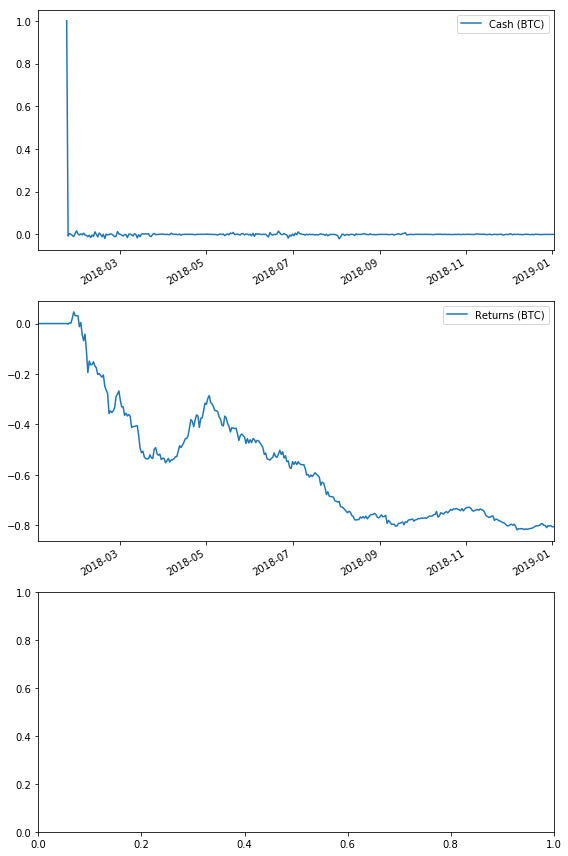

In [15]:
algorithm_results = run_algorithm(
    capital_base=BASE_CAPITAL,
    start=pd.to_datetime(START_DATE, utc=True),
    end=pd.to_datetime(END_DATE, utc=True),
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    data_frequency=API_FREQUENCY,
    live=False,
    exchange_name=EXCHANGE_NAME,
    quote_currency=BASE_CURRENCY,
    algo_namespace='test',
    live_graph=False
)

#returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(algorithm_results)
#pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')